In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import contextily as ctx

C:\Users\mohan\AppData\Local\Temp\ipykernel_16476\2073117998.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(central_points['x'],


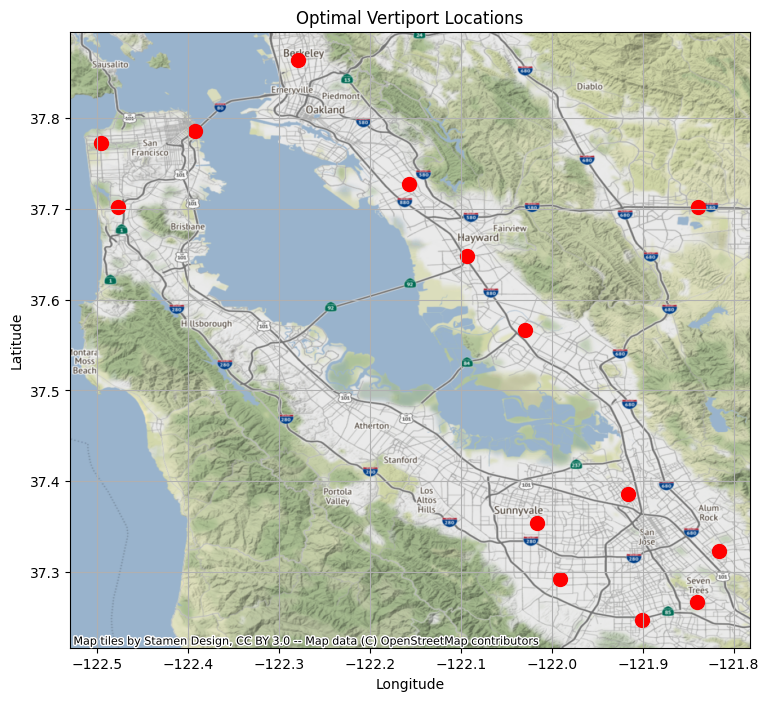

In [2]:
data = pd.read_csv('./data_with_cluster_labels.csv')

# List of cluster_label values for which you want to get the central points
selected_cluster_labels = [ 105, 72, 75, 47, 97, 40, 36, 60, 33, 11, 82, 17, 92, 112]
# 17

# Filter the DataFrame for the selected cluster_label values
selected_data = data[data['cluster_label'].isin(selected_cluster_labels)]

# Calculate the central point (mean x and y) for each cluster
central_points = selected_data.groupby('cluster_label').agg({'x': 'mean', 'y': 'mean'}).reset_index()

# Define your own ax (axes)
fig, ax = plt.subplots(figsize=(10, 8))

# Create a scatter plot
scatter = ax.scatter(central_points['x'],
                     central_points['y'],
                     c='red',
                     cmap='viridis', s=100)

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Optimal Vertiport Locations')

# Display the grid
ax.grid(True)

# Add basemap using contextily
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Stamen.Terrain)

# Show the plot
plt.show()


## Importing and Preprocessing Data

Vertiport Binary + Distance Matrix

In [3]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert coordinates from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 

    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371.0

    # Calculate the result
    return c * r

vertiport_connection = pd.read_csv('random_sets.csv').iloc[:125,:]
split = vertiport_connection['Numbers'].str.split(",")
vertiport_connection = np.zeros((125, 20))
for i in range(125):
    idx = np.array(split[i], dtype=int)-1
    vertiport_connection[i,idx] = 1
y = pd.read_csv('total_travel_time.csv')['total_travel_time'].to_numpy()
data_with_cluster_labels = pd.read_csv('data_with_cluster_labels.csv')
data_with_cluster_labels_nonull = data_with_cluster_labels[data_with_cluster_labels['cluster_label'].notna()]
data_with_cluster_labels_nonull_20 = data_with_cluster_labels_nonull[(data_with_cluster_labels_nonull['cluster_label'] <= 20) & (data_with_cluster_labels_nonull['cluster_label'] >= 1)]
# Calculate the mean of x and y for each cluster
data_with_cluster_labels_nonull_20_grouped = data_with_cluster_labels_nonull_20.groupby('cluster_label').agg({'x': 'mean', 'y': 'mean'}).reset_index()

# Rename columns
data_with_cluster_labels_nonull_20_grouped.columns = ['cluster_label', 'mean_x', 'mean_y']
vertiport_loc_dic = {}
for i in range(20):
    vertiport_loc_dic[i+1] = (data_with_cluster_labels_nonull_20_grouped['mean_x'][i], data_with_cluster_labels_nonull_20_grouped['mean_y'][i])
vertiport_network_before_reshape = np.zeros((125, 20, 20))
for i in range(125):
    for j in range(20):
        for k in range(20):
            if vertiport_connection[i, j] == 1 and vertiport_connection[i, k] == 1:
                vertiport_network_before_reshape[i, j, k] = haversine(vertiport_loc_dic[j+1][1], vertiport_loc_dic[j+1][0], vertiport_loc_dic[k+1][1], vertiport_loc_dic[k+1][0])
vertiport_network = vertiport_network_before_reshape.reshape(125, 400)
x = np.concatenate((vertiport_connection, vertiport_network), axis=1)


Demand

In [4]:
demand = pd.read_csv('./Proj/OD_UAM_Suitable.csv')
demand_with_origin_cluster = pd.merge(
    demand,
    data_with_cluster_labels_nonull_20[['osmid', 'cluster_label']],
    left_on='origin_osmid',
    right_on='osmid',
    how='left'
)
# Drop the duplicate 'osmid' column that resulted from the merge
demand_with_origin_cluster.drop('osmid', axis=1, inplace=True)

# Rename the 'cluster_label' column to 'origin_cluster_label'
demand_with_origin_cluster.rename(columns={'cluster_label': 'origin_cluster_label'}, inplace=True)

# Step 2: Merge on "destination_osmid"
demand_with_both_clusters = pd.merge(
    demand_with_origin_cluster,
    data_with_cluster_labels_nonull_20[['osmid', 'cluster_label']],
    left_on='destination_osmid',
    right_on='osmid',
    how='left'
)

# Drop the duplicate 'osmid' column that resulted from the merge
demand_with_both_clusters.drop('osmid', axis=1, inplace=True)

# Rename the 'cluster_label' column to 'destination_cluster_label'
demand_with_both_clusters.rename(columns={'cluster_label': 'destination_cluster_label'}, inplace=True)

# Drop rows where either "origin_cluster_label" or "destination_cluster_label" is NaN
demand_with_both_clusters = demand_with_both_clusters.dropna(subset=['origin_cluster_label', 'destination_cluster_label'])
demand_with_both_clusters = demand_with_both_clusters[demand_with_both_clusters['origin_cluster_label'] != demand_with_both_clusters['destination_cluster_label']]


# Step 1: Create a pivot table to count the occurrences of each combination of "origin_cluster_label" and "destination_cluster_label"
pivot_table = demand_with_both_clusters.pivot_table(
    index='origin_cluster_label',
    columns='destination_cluster_label',
    values='distance',
    aggfunc='count',
    fill_value=0
)

# Step 2: Reindex the pivot table to ensure it has a 20x20 shape
# (Note: If there are any missing cluster labels in the original data, the reindex will add them and fill with zeros.)
cluster_labels = range(1, 21)  # Assuming cluster labels range from 1 to 20
pivot_table = pivot_table.reindex(index=cluster_labels, columns=cluster_labels, fill_value=0)

# The resulting "pivot_table" is a 20x20 matrix where each cell (i, j) represents the count of occurrences from cluster i to cluster j.
demand_matrix = pivot_table.to_numpy()
vertiport_demand = np.zeros((125, 20, 20))
for i in range(125):
    # Create a new matrix by combining the values from "matrix" and "original_matrix"
    vertiport_demand[i] = np.where(vertiport_network_before_reshape[i] != 0, demand_matrix, 0)
vertiport_demand = vertiport_demand.reshape(125, 400)
x = np.concatenate((x, vertiport_demand), axis=1)

Road Type

In [5]:
edge = pd.read_csv('./Proj/edges.csv')
node = pd.read_csv('./Proj/nodes.csv')
edge_connected = pd.merge(
    edge,
    node,
    left_on='osmid_u',
    right_on='osmid',
    how='left'
)
import pandas as pd
import numpy as np

# Function to calculate Haversine distance between two points
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth's radius in km
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Create a new dataframe to store the results
result_df = pd.DataFrame(columns=["cluster_label", "edge_id", "distance", "length", "speed_mph"])

# Iterate through each row in the "data_with_cluster_labels_nonull_20_grouped" dataframe
for _, row in data_with_cluster_labels_nonull_20_grouped.iterrows():
    cluster_label = row["cluster_label"]
    mean_x = row["mean_x"]
    mean_y = row["mean_y"]

    # Calculate distance between the point in the current row and all edges in "edge_connected"
    edge_connected["distance"] = haversine_distance(mean_y, mean_x, edge_connected["y"], edge_connected["x"])

    # Sort edges based on distance and select the top 5 closest edges
    closest_edges = edge_connected.nsmallest(5, "distance")[["uniqueid", "distance", "length", "speed_mph"]]

    # Add the cluster_label to the closest_edges dataframe
    closest_edges["cluster_label"] = cluster_label

    # Concatenate the closest_edges dataframe with the result_df
    result_df = pd.concat([result_df, closest_edges])

# Reset the index of the result_df
result_df.reset_index(drop=True, inplace=True)

print(result_df)
length_matrix = np.zeros((20, 5))
speed_matrix = np.zeros((20, 5))
k = 0
for i in range(20):
    for j in range(5):
        length_matrix[i][j] = result_df['length'][k]
        speed_matrix[i][j] = result_df['speed_mph'][k]
        k = k + 1      
        
lengths_matrix = np.zeros((125, 20, 5))
speeds_matrix = np.zeros((125, 20, 5)) 
for i in range(125):
    for j in range(20):
        if (vertiport_connection[i][j] == 1):
            lengths_matrix[i][j] = length_matrix[j]
            speeds_matrix[i][j] = speed_matrix[j]

road_length = lengths_matrix.reshape(125, 100)
x = np.concatenate((x, road_length), axis=1)
road_speed = speeds_matrix.reshape(125, 100)
x = np.concatenate((x, road_speed), axis=1)


    cluster_label edge_id  distance   length speed_mph  uniqueid
0             1.0     NaN  0.041838  116.939        20  111624.0
1             1.0     NaN  0.106082  160.880        20   90918.0
2             1.0     NaN  0.106082   87.901        20   90919.0
3             1.0     NaN  0.106082  226.530        20   90920.0
4             1.0     NaN  0.118863   86.390        20   83563.0
..            ...     ...       ...      ...       ...       ...
95           20.0     NaN  0.124070  267.641        20  542672.0
96           20.0     NaN  0.124070  202.105        20  542673.0
97           20.0     NaN  0.124070  308.362        20  542674.0
98           20.0     NaN  0.131699  278.978        25  171411.0
99           20.0     NaN  0.131699  277.571        25  171412.0

[100 rows x 6 columns]


Data Split

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(100, 1020)
(25, 1020)
(100,)
(25,)


In [8]:
# from sklearn.decomposition import PCA

# # Assuming you have:
# # x_train of shape (100, 1020)
# # x_test of shape (25, 1020)
# # y_train of shape (100,)
# # y_test of shape (25,)

# # Initialize PCA; n_components < min(n_samples, n_features)
# pca = PCA(n_components=50) 

# # Fit PCA on training data and apply the transformation to both training and test data
# x_train = pca.fit_transform(x_train)
# x_test = pca.transform(x_test)


## RandomForest Regression

Using Optuna to optimize hyper parameters

In [9]:
import optuna
from sklearn.ensemble import RandomForestRegressor

# how we will rate the preformace of the model
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def objective(trial):
    # the params we want to tune
    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 1, 100),
        'max_depth' : trial.suggest_int('max_depth', 3, 50),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2, 50),
        'max_features' : trial.suggest_int('max_features', 5, 50)
    }

    # make and fit the model
    model = RandomForestRegressor(**params, random_state=42)
    model.fit(x_train, y_train)

    # return how well the model is doing
    predicted = model.predict(x_test)
    return mean_absolute_percentage_error(y_test, predicted)

# create the study and optimize the hyperparams
randomForestStudy = optuna.create_study(direction='minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
randomForestStudy.optimize(objective, n_trials=500, show_progress_bar=True)

c:\Users\mohan\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-07-31 10:43:37,908] A new study created in memory with name: no-name-3da9b097-4611-4da9-9bb7-17a683233c49
Best trial: 341. Best value: 0.0420232: 100%|██████████| 500/500 [00:36<00:00, 13.88it/s]


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

RFparams = RandomForestRegressor(**randomForestStudy.best_trial.params, random_state=42)
RFparams.fit(x_train, y_train)
RFpredicted = RFparams.predict(x_test)

print(randomForestStudy.best_trial.params)
print('MAE: ', mean_absolute_error(y_test, RFpredicted))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, RFpredicted)))
print('MAPE: ', mean_absolute_percentage_error(y_test, RFpredicted))

{'n_estimators': 3, 'max_depth': 34, 'min_samples_split': 14, 'max_features': 48}
MAE:  951648.5781435585
RMSE:  1032843.894911154
MAPE:  0.04202324237020485


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
grid = {'n_estimators': [i for i in range(1,20)],
        'min_samples_split': [i for i in range(2,10)],
        'max_features' : [i for i in range(8, 20, 2)]}
cv_rf = GridSearchCV(estimator = RandomForestRegressor(), param_grid=grid, verbose=0, cv = 3, n_jobs = -1)
fitted = cv_rf.fit(x_train, y_train)

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
sampled_yhat = fitted.best_estimator_.predict(x_test)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

sampled_yhat = fitted.best_estimator_.predict(x_test)
print('MAE: ', mean_absolute_error(y_test, sampled_yhat))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, sampled_yhat)))
print('MAPE: ', mean_absolute_percentage_error(y_test, sampled_yhat))

# print('MAE: ', mean_absolute_error(y_test, sampled_yhat), 'RMSE: ', np.sqrt(mean_squared_error(y_test, sampled_yhat)))

MAE:  1222930.0420829963
RMSE:  1417064.1984477444
MAPE:  0.05399827084656185


In [13]:
fitted.best_estimator_

RandomForestRegressor(max_features=14, min_samples_split=4, n_estimators=6)

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
sampled_yhat = fitted.best_estimator_.predict(x_test)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

sampled_yhat = fitted.best_estimator_.predict(x_test)
print('MAE: ', mean_absolute_error(y_test, sampled_yhat))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, sampled_yhat)))
print('MAPE: ', mean_absolute_percentage_error(y_test, sampled_yhat))

# print('MAE: ', mean_absolute_error(y_test, sampled_yhat), 'RMSE: ', np.sqrt(mean_squared_error(y_test, sampled_yhat)))

MAE:  1222930.0420829963
RMSE:  1417064.1984477444
MAPE:  0.05399827084656185


## XGBoost

In [15]:
from xgboost import XGBRegressor

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
    }

    model = XGBRegressor(**params, seed=42)
    model.fit(x_train, y_train)
    predicted = model.predict(x_test)
    return mean_absolute_percentage_error(y_test, predicted)

XGBoostStudy = optuna.create_study(direction='minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
XGBoostStudy.optimize(objective, n_trials=500, show_progress_bar=True)

  0%|          | 0/500 [00:00<?, ?it/s]

Best trial: 354. Best value: 0.0449273: 100%|██████████| 500/500 [12:01<00:00,  1.44s/it]


In [16]:
XGBoostParams = XGBRegressor(**XGBoostStudy.best_trial.params, seed=42)
XGBoostParams.fit(x_train, y_train)
XGBoostPredicted = XGBoostParams.predict(x_test)

print('MAE: ', mean_absolute_error(y_test, XGBoostPredicted))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, XGBoostPredicted)))
print('MAPE: ', mean_absolute_percentage_error(y_test, XGBoostPredicted))

MAE:  1017819.28
RMSE:  1350084.354876124
MAPE:  0.04492732510883036


In [17]:
from xgboost import XGBRegressor
grid = {'n_estimators': [i for i in range(1,20)]}
cv_rf = GridSearchCV(estimator = XGBRegressor(), param_grid=grid, verbose=0, cv = 3, n_jobs = -1)
fitted = cv_rf.fit(x_train, y_train)

In [18]:
sampled_yhat = fitted.best_estimator_.predict(x_test)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

sampled_yhat = fitted.best_estimator_.predict(x_test)
print('MAE: ', mean_absolute_error(y_test, sampled_yhat))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, sampled_yhat)))
print('MAPE: ', mean_absolute_percentage_error(y_test, sampled_yhat))
print('MAE: ', mean_absolute_error(y_test, sampled_yhat), 'RMSE: ', np.sqrt(mean_squared_error(y_test, sampled_yhat)))

MAE:  2624167.76
RMSE:  2922967.6999258134
MAPE:  0.11584673534571426
MAE:  2624167.76 RMSE:  2922967.6999258134


In [19]:
sampled_yhat = fitted.best_estimator_.predict(x_train)
print('MAE: ', mean_absolute_error(y_train, sampled_yhat), 'RMSE: ', np.sqrt(mean_squared_error(y_train, sampled_yhat)))
sampled_yhat = fitted.best_estimator_.predict(x_test)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

sampled_yhat = fitted.best_estimator_.predict(x_test)
print('MAE: ', mean_absolute_error(y_test, sampled_yhat))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, sampled_yhat)))
print('MAPE: ', mean_absolute_percentage_error(y_test, sampled_yhat))
print('MAE: ', mean_absolute_error(y_test, sampled_yhat), 'RMSE: ', np.sqrt(mean_squared_error(y_test, sampled_yhat)))

MAE:  2797879.63 RMSE:  3045582.6903246953
MAE:  2624167.76
RMSE:  2922967.6999258134
MAPE:  0.11584673534571426
MAE:  2624167.76 RMSE:  2922967.6999258134


## NN

In [20]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.backend import clear_session
from sklearn.preprocessing import StandardScaler
import optuna

# Normalize the input
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train_nn = x_scaler.fit_transform(x_train)
y_train_nn = y_scaler.fit_transform(y_train.reshape(-1,1))
x_test_nn = x_scaler.transform(x_test)
y_test_nn = y_scaler.transform(y_test.reshape(-1,1))

def objective(trial):
    clear_session()

    # make the model
    keras.utils.set_random_seed(42)

    model = keras.Sequential()
    model.add(keras.layers.Dense(trial.suggest_int('Layer1', 64, 512), trial.suggest_categorical('activation1', ['relu', 'tanh', 'softmax'])))
    model.add(keras.layers.Dense(trial.suggest_int('Layer2', 64, 512), trial.suggest_categorical('activation2', ['relu', 'tanh', 'softmax'])))
    model.add(keras.layers.Dense(trial.suggest_int('Layer3', 64, 512), trial.suggest_categorical('activation3', ['relu', 'tanh', 'softmax'])))
    model.add(keras.layers.Dense(1))
    optimizer = optimizers.Nadam(learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-1))
    model.compile(loss = 'mse', optimizer = optimizer)

    # train the model
    model.fit(x_train_nn, y_train_nn[:,np.newaxis], epochs=500, batch_size=32, verbose = 0)
    predicted = y_scaler.inverse_transform(model.predict(x_test_nn).reshape(-1,1))
    return mean_absolute_percentage_error(y_test, predicted)

# create the study and optimize
NNStudy = optuna.create_study(direction='minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
NNStudy.optimize(objective, n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 108ms/step


Best trial: 0. Best value: 0.0572818:   0%|          | 1/200 [00:12<42:52, 12.92s/it]

1/1 [==============================] - 0s 74ms/step


Best trial: 1. Best value: 0.0506224:   1%|          | 2/200 [00:25<42:52, 12.99s/it]

1/1 [==============================] - 0s 85ms/step


Best trial: 1. Best value: 0.0506224:   2%|▏         | 3/200 [00:38<42:30, 12.95s/it]

1/1 [==============================] - 0s 84ms/step


Best trial: 3. Best value: 0.0504636:   2%|▏         | 4/200 [01:03<57:27, 17.59s/it]

1/1 [==============================] - 0s 69ms/step


Best trial: 3. Best value: 0.0504636:   2%|▎         | 5/200 [01:12<46:42, 14.37s/it]

1/1 [==============================] - 0s 80ms/step


Best trial: 3. Best value: 0.0504636:   3%|▎         | 6/200 [01:33<53:44, 16.62s/it]

1/1 [==============================] - 0s 65ms/step


Best trial: 3. Best value: 0.0504636:   4%|▎         | 7/200 [01:53<56:52, 17.68s/it]

1/1 [==============================] - 0s 81ms/step


Best trial: 7. Best value: 0.0496767:   4%|▍         | 8/200 [02:01<47:14, 14.76s/it]

1/1 [==============================] - 0s 81ms/step


Best trial: 8. Best value: 0.0490683:   4%|▍         | 9/200 [02:11<42:11, 13.25s/it]

1/1 [==============================] - 0s 70ms/step


Best trial: 8. Best value: 0.0490683:   5%|▌         | 10/200 [02:21<39:10, 12.37s/it]

1/1 [==============================] - 0s 77ms/step


Best trial: 10. Best value: 0.0489372:   6%|▌         | 11/200 [02:38<43:27, 13.79s/it]

1/1 [==============================] - 0s 69ms/step


Best trial: 10. Best value: 0.0489372:   6%|▌         | 12/200 [02:56<46:28, 14.83s/it]

1/1 [==============================] - 0s 77ms/step


Best trial: 12. Best value: 0.0487197:   6%|▋         | 13/200 [03:14<49:26, 15.86s/it]

1/1 [==============================] - 0s 72ms/step


Best trial: 13. Best value: 0.0487061:   7%|▋         | 14/200 [03:31<50:45, 16.37s/it]

1/1 [==============================] - 0s 74ms/step


Best trial: 13. Best value: 0.0487061:   8%|▊         | 15/200 [03:51<53:10, 17.24s/it]

1/1 [==============================] - 0s 88ms/step


Best trial: 13. Best value: 0.0487061:   8%|▊         | 16/200 [04:15<59:20, 19.35s/it]

1/1 [==============================] - 0s 91ms/step


Best trial: 13. Best value: 0.0487061:   8%|▊         | 17/200 [04:35<59:49, 19.61s/it]

1/1 [==============================] - 0s 73ms/step


Best trial: 13. Best value: 0.0487061:   9%|▉         | 18/200 [04:54<59:00, 19.46s/it]

1/1 [==============================] - 0s 87ms/step


Best trial: 13. Best value: 0.0487061:  10%|▉         | 19/200 [05:12<57:27, 19.05s/it]

1/1 [==============================] - 0s 81ms/step


Best trial: 13. Best value: 0.0487061:  10%|█         | 20/200 [05:36<1:01:41, 20.56s/it]

1/1 [==============================] - 0s 65ms/step


Best trial: 13. Best value: 0.0487061:  10%|█         | 21/200 [05:52<57:09, 19.16s/it]  

1/1 [==============================] - 0s 69ms/step


Best trial: 13. Best value: 0.0487061:  11%|█         | 22/200 [06:09<55:02, 18.55s/it]

1/1 [==============================] - 0s 70ms/step


Best trial: 13. Best value: 0.0487061:  12%|█▏        | 23/200 [06:27<53:52, 18.26s/it]

1/1 [==============================] - 0s 75ms/step


Best trial: 13. Best value: 0.0487061:  12%|█▏        | 24/200 [06:45<53:04, 18.09s/it]

1/1 [==============================] - 0s 72ms/step


Best trial: 13. Best value: 0.0487061:  12%|█▎        | 25/200 [07:02<52:06, 17.87s/it]

1/1 [==============================] - 0s 77ms/step


Best trial: 13. Best value: 0.0487061:  13%|█▎        | 26/200 [07:22<54:00, 18.62s/it]

1/1 [==============================] - 0s 75ms/step


Best trial: 13. Best value: 0.0487061:  14%|█▎        | 27/200 [07:33<46:37, 16.17s/it]

1/1 [==============================] - 0s 73ms/step


Best trial: 13. Best value: 0.0487061:  14%|█▍        | 28/200 [07:44<42:12, 14.72s/it]

1/1 [==============================] - 0s 79ms/step


Best trial: 13. Best value: 0.0487061:  14%|█▍        | 29/200 [08:04<46:19, 16.26s/it]

1/1 [==============================] - 0s 78ms/step


Best trial: 13. Best value: 0.0487061:  15%|█▌        | 30/200 [08:24<49:17, 17.40s/it]

1/1 [==============================] - 0s 75ms/step


Best trial: 13. Best value: 0.0487061:  16%|█▌        | 31/200 [08:46<52:42, 18.71s/it]

1/1 [==============================] - 0s 63ms/step


Best trial: 13. Best value: 0.0487061:  16%|█▌        | 32/200 [09:05<52:24, 18.72s/it]

1/1 [==============================] - 0s 78ms/step


Best trial: 13. Best value: 0.0487061:  16%|█▋        | 33/200 [09:23<51:35, 18.53s/it]

1/1 [==============================] - 0s 61ms/step


Best trial: 13. Best value: 0.0487061:  17%|█▋        | 34/200 [09:43<53:03, 19.18s/it]

1/1 [==============================] - 0s 69ms/step


Best trial: 13. Best value: 0.0487061:  18%|█▊        | 35/200 [10:03<52:45, 19.19s/it]

1/1 [==============================] - 0s 68ms/step


Best trial: 13. Best value: 0.0487061:  18%|█▊        | 36/200 [10:20<50:40, 18.54s/it]

1/1 [==============================] - 0s 62ms/step


Best trial: 13. Best value: 0.0487061:  18%|█▊        | 37/200 [10:31<44:03, 16.22s/it]

1/1 [==============================] - 0s 78ms/step


Best trial: 13. Best value: 0.0487061:  19%|█▉        | 38/200 [10:52<48:07, 17.82s/it]

1/1 [==============================] - 0s 61ms/step


Best trial: 13. Best value: 0.0487061:  20%|█▉        | 39/200 [11:13<50:00, 18.64s/it]

1/1 [==============================] - 0s 67ms/step


Best trial: 13. Best value: 0.0487061:  20%|██        | 40/200 [11:32<50:07, 18.80s/it]

1/1 [==============================] - 0s 71ms/step


Best trial: 13. Best value: 0.0487061:  20%|██        | 41/200 [11:53<51:52, 19.58s/it]

1/1 [==============================] - 0s 62ms/step


Best trial: 13. Best value: 0.0487061:  21%|██        | 42/200 [12:10<49:28, 18.79s/it]

1/1 [==============================] - 0s 67ms/step


Best trial: 42. Best value: 0.0487038:  22%|██▏       | 43/200 [12:25<46:28, 17.76s/it]

1/1 [==============================] - 0s 70ms/step


Best trial: 42. Best value: 0.0487038:  22%|██▏       | 44/200 [12:41<44:08, 16.98s/it]

1/1 [==============================] - 0s 66ms/step


Best trial: 42. Best value: 0.0487038:  22%|██▎       | 45/200 [12:50<37:56, 14.69s/it]

1/1 [==============================] - 0s 138ms/step


Best trial: 42. Best value: 0.0487038:  23%|██▎       | 46/200 [13:10<41:34, 16.20s/it]

1/1 [==============================] - 0s 64ms/step


Best trial: 42. Best value: 0.0487038:  24%|██▎       | 47/200 [13:26<41:01, 16.09s/it]

1/1 [==============================] - 0s 68ms/step


Best trial: 42. Best value: 0.0487038:  24%|██▍       | 48/200 [13:45<43:32, 17.19s/it]

1/1 [==============================] - 0s 68ms/step


Best trial: 42. Best value: 0.0487038:  24%|██▍       | 49/200 [14:04<44:29, 17.68s/it]

1/1 [==============================] - 0s 64ms/step


Best trial: 42. Best value: 0.0487038:  25%|██▌       | 50/200 [14:20<42:45, 17.10s/it]

1/1 [==============================] - 0s 63ms/step


Best trial: 42. Best value: 0.0487038:  26%|██▌       | 51/200 [14:31<38:04, 15.34s/it]

1/1 [==============================] - 0s 69ms/step


Best trial: 42. Best value: 0.0487038:  26%|██▌       | 52/200 [14:49<39:44, 16.11s/it]

1/1 [==============================] - 0s 77ms/step


Best trial: 42. Best value: 0.0487038:  26%|██▋       | 53/200 [15:08<41:37, 16.99s/it]

1/1 [==============================] - 0s 63ms/step


Best trial: 42. Best value: 0.0487038:  27%|██▋       | 54/200 [15:28<43:25, 17.84s/it]

1/1 [==============================] - 0s 67ms/step


Best trial: 42. Best value: 0.0487038:  28%|██▊       | 55/200 [15:48<44:51, 18.56s/it]

1/1 [==============================] - 0s 75ms/step


Best trial: 42. Best value: 0.0487038:  28%|██▊       | 56/200 [16:06<44:18, 18.46s/it]

1/1 [==============================] - 0s 64ms/step


Best trial: 42. Best value: 0.0487038:  28%|██▊       | 57/200 [16:25<44:24, 18.63s/it]

1/1 [==============================] - 0s 57ms/step


Best trial: 42. Best value: 0.0487038:  29%|██▉       | 58/200 [16:43<43:17, 18.29s/it]

1/1 [==============================] - 0s 76ms/step


Best trial: 42. Best value: 0.0487038:  30%|██▉       | 59/200 [16:58<41:00, 17.45s/it]

1/1 [==============================] - 0s 66ms/step


Best trial: 42. Best value: 0.0487038:  30%|███       | 60/200 [17:17<41:48, 17.92s/it]

1/1 [==============================] - 0s 82ms/step


Best trial: 42. Best value: 0.0487038:  30%|███       | 61/200 [17:33<39:57, 17.25s/it]

1/1 [==============================] - 0s 61ms/step


Best trial: 42. Best value: 0.0487038:  31%|███       | 62/200 [17:51<39:57, 17.37s/it]

1/1 [==============================] - 0s 79ms/step


Best trial: 42. Best value: 0.0487038:  32%|███▏      | 63/200 [18:12<42:09, 18.46s/it]

1/1 [==============================] - 0s 83ms/step


Best trial: 42. Best value: 0.0487038:  32%|███▏      | 64/200 [18:32<43:06, 19.02s/it]

1/1 [==============================] - 0s 77ms/step


Best trial: 42. Best value: 0.0487038:  32%|███▎      | 65/200 [18:41<36:19, 16.14s/it]

1/1 [==============================] - 0s 70ms/step


Best trial: 42. Best value: 0.0487038:  33%|███▎      | 66/200 [19:04<40:19, 18.06s/it]

1/1 [==============================] - 0s 61ms/step


Best trial: 42. Best value: 0.0487038:  34%|███▎      | 67/200 [19:22<39:46, 17.94s/it]

1/1 [==============================] - 0s 68ms/step


Best trial: 42. Best value: 0.0487038:  34%|███▍      | 68/200 [19:39<39:15, 17.85s/it]

1/1 [==============================] - 0s 60ms/step


Best trial: 42. Best value: 0.0487038:  34%|███▍      | 69/200 [19:57<38:41, 17.72s/it]

1/1 [==============================] - 0s 80ms/step


Best trial: 42. Best value: 0.0487038:  35%|███▌      | 70/200 [20:16<39:23, 18.18s/it]

1/1 [==============================] - 0s 66ms/step


Best trial: 42. Best value: 0.0487038:  36%|███▌      | 71/200 [20:34<38:42, 18.00s/it]

1/1 [==============================] - 0s 74ms/step


Best trial: 42. Best value: 0.0487038:  36%|███▌      | 72/200 [20:53<39:08, 18.35s/it]

1/1 [==============================] - 0s 75ms/step


Best trial: 42. Best value: 0.0487038:  36%|███▋      | 73/200 [21:12<39:41, 18.75s/it]

1/1 [==============================] - 0s 68ms/step


Best trial: 42. Best value: 0.0487038:  37%|███▋      | 74/200 [21:37<43:21, 20.64s/it]

1/1 [==============================] - 0s 73ms/step


Best trial: 42. Best value: 0.0487038:  38%|███▊      | 75/200 [21:55<41:21, 19.85s/it]

1/1 [==============================] - 0s 72ms/step


Best trial: 75. Best value: 0.0486852:  38%|███▊      | 76/200 [22:12<39:09, 18.95s/it]

1/1 [==============================] - 0s 62ms/step


Best trial: 75. Best value: 0.0486852:  38%|███▊      | 77/200 [22:27<36:23, 17.76s/it]

1/1 [==============================] - 0s 72ms/step


Best trial: 75. Best value: 0.0486852:  39%|███▉      | 78/200 [22:44<35:13, 17.32s/it]

1/1 [==============================] - 0s 73ms/step


Best trial: 75. Best value: 0.0486852:  40%|███▉      | 79/200 [23:01<35:09, 17.44s/it]

1/1 [==============================] - 0s 76ms/step


Best trial: 75. Best value: 0.0486852:  40%|████      | 80/200 [23:22<37:04, 18.53s/it]

1/1 [==============================] - 0s 72ms/step


Best trial: 75. Best value: 0.0486852:  40%|████      | 81/200 [23:42<37:13, 18.77s/it]

1/1 [==============================] - 0s 67ms/step


Best trial: 75. Best value: 0.0486852:  41%|████      | 82/200 [23:58<35:34, 18.09s/it]

1/1 [==============================] - 0s 72ms/step


Best trial: 75. Best value: 0.0486852:  42%|████▏     | 83/200 [24:15<34:16, 17.58s/it]

1/1 [==============================] - 0s 66ms/step


Best trial: 75. Best value: 0.0486852:  42%|████▏     | 84/200 [24:31<33:25, 17.29s/it]

1/1 [==============================] - 0s 70ms/step


Best trial: 75. Best value: 0.0486852:  42%|████▎     | 85/200 [24:50<34:06, 17.79s/it]

1/1 [==============================] - 0s 65ms/step


Best trial: 75. Best value: 0.0486852:  43%|████▎     | 86/200 [25:09<34:33, 18.19s/it]

1/1 [==============================] - 0s 62ms/step


Best trial: 75. Best value: 0.0486852:  44%|████▎     | 87/200 [25:24<32:25, 17.22s/it]

1/1 [==============================] - 0s 73ms/step


Best trial: 75. Best value: 0.0486852:  44%|████▍     | 88/200 [25:40<31:35, 16.92s/it]

1/1 [==============================] - 0s 69ms/step


Best trial: 75. Best value: 0.0486852:  44%|████▍     | 89/200 [26:02<33:39, 18.19s/it]

1/1 [==============================] - 0s 70ms/step


Best trial: 75. Best value: 0.0486852:  45%|████▌     | 90/200 [26:23<35:01, 19.10s/it]

1/1 [==============================] - 0s 78ms/step


Best trial: 75. Best value: 0.0486852:  46%|████▌     | 91/200 [26:41<33:54, 18.67s/it]

1/1 [==============================] - 0s 80ms/step


Best trial: 75. Best value: 0.0486852:  46%|████▌     | 92/200 [27:00<34:05, 18.94s/it]

1/1 [==============================] - 0s 78ms/step


Best trial: 75. Best value: 0.0486852:  46%|████▋     | 93/200 [27:19<33:48, 18.96s/it]

1/1 [==============================] - 0s 82ms/step


Best trial: 75. Best value: 0.0486852:  47%|████▋     | 94/200 [27:41<35:15, 19.96s/it]

1/1 [==============================] - 0s 75ms/step


Best trial: 75. Best value: 0.0486852:  48%|████▊     | 95/200 [28:01<34:39, 19.80s/it]

1/1 [==============================] - 0s 80ms/step


Best trial: 75. Best value: 0.0486852:  48%|████▊     | 96/200 [28:22<34:46, 20.06s/it]

1/1 [==============================] - 0s 73ms/step


Best trial: 75. Best value: 0.0486852:  48%|████▊     | 97/200 [28:47<37:03, 21.59s/it]

1/1 [==============================] - 0s 67ms/step


Best trial: 75. Best value: 0.0486852:  49%|████▉     | 98/200 [29:04<34:41, 20.41s/it]

1/1 [==============================] - 0s 71ms/step


Best trial: 75. Best value: 0.0486852:  50%|████▉     | 99/200 [29:24<34:00, 20.20s/it]

1/1 [==============================] - 0s 82ms/step


Best trial: 75. Best value: 0.0486852:  50%|█████     | 100/200 [29:42<32:27, 19.47s/it]

1/1 [==============================] - 0s 77ms/step


Best trial: 75. Best value: 0.0486852:  50%|█████     | 101/200 [30:01<31:45, 19.25s/it]

1/1 [==============================] - 0s 75ms/step


Best trial: 75. Best value: 0.0486852:  51%|█████     | 102/200 [30:21<31:59, 19.59s/it]

1/1 [==============================] - 0s 69ms/step


Best trial: 75. Best value: 0.0486852:  52%|█████▏    | 103/200 [30:43<32:46, 20.28s/it]

1/1 [==============================] - 0s 75ms/step


Best trial: 75. Best value: 0.0486852:  52%|█████▏    | 104/200 [31:03<32:15, 20.16s/it]

1/1 [==============================] - 0s 67ms/step


Best trial: 75. Best value: 0.0486852:  52%|█████▎    | 105/200 [31:21<31:01, 19.60s/it]

1/1 [==============================] - 0s 72ms/step


Best trial: 75. Best value: 0.0486852:  53%|█████▎    | 106/200 [31:46<33:28, 21.37s/it]

1/1 [==============================] - 0s 76ms/step


Best trial: 75. Best value: 0.0486852:  54%|█████▎    | 107/200 [32:07<32:52, 21.21s/it]

1/1 [==============================] - 0s 73ms/step


Best trial: 75. Best value: 0.0486852:  54%|█████▍    | 108/200 [32:29<32:42, 21.33s/it]

1/1 [==============================] - 0s 78ms/step


Best trial: 75. Best value: 0.0486852:  55%|█████▍    | 109/200 [32:47<30:58, 20.42s/it]

1/1 [==============================] - 0s 68ms/step


Best trial: 75. Best value: 0.0486852:  55%|█████▌    | 110/200 [33:09<31:02, 20.70s/it]

1/1 [==============================] - 0s 71ms/step


Best trial: 75. Best value: 0.0486852:  56%|█████▌    | 111/200 [33:31<31:21, 21.14s/it]

1/1 [==============================] - 0s 69ms/step


Best trial: 75. Best value: 0.0486852:  56%|█████▌    | 112/200 [33:51<30:46, 20.98s/it]

1/1 [==============================] - 0s 71ms/step


Best trial: 75. Best value: 0.0486852:  56%|█████▋    | 113/200 [34:12<30:19, 20.91s/it]

1/1 [==============================] - 0s 79ms/step


Best trial: 75. Best value: 0.0486852:  57%|█████▋    | 114/200 [34:35<31:00, 21.64s/it]

1/1 [==============================] - 0s 76ms/step


Best trial: 75. Best value: 0.0486852:  57%|█████▊    | 115/200 [35:02<32:51, 23.20s/it]

1/1 [==============================] - 0s 71ms/step


Best trial: 75. Best value: 0.0486852:  58%|█████▊    | 116/200 [35:27<33:11, 23.71s/it]

1/1 [==============================] - 0s 73ms/step


Best trial: 75. Best value: 0.0486852:  58%|█████▊    | 117/200 [35:54<33:55, 24.53s/it]

1/1 [==============================] - 0s 69ms/step


Best trial: 75. Best value: 0.0486852:  59%|█████▉    | 118/200 [36:21<34:52, 25.52s/it]

1/1 [==============================] - 0s 67ms/step


Best trial: 75. Best value: 0.0486852:  60%|█████▉    | 119/200 [36:44<33:19, 24.68s/it]

1/1 [==============================] - 0s 75ms/step


Best trial: 75. Best value: 0.0486852:  60%|██████    | 120/200 [37:09<33:05, 24.82s/it]

1/1 [==============================] - 0s 100ms/step


Best trial: 75. Best value: 0.0486852:  60%|██████    | 121/200 [37:32<31:48, 24.15s/it]

1/1 [==============================] - 0s 61ms/step


Best trial: 75. Best value: 0.0486852:  61%|██████    | 122/200 [37:54<30:32, 23.49s/it]

1/1 [==============================] - 0s 73ms/step


Best trial: 75. Best value: 0.0486852:  62%|██████▏   | 123/200 [38:18<30:28, 23.74s/it]

1/1 [==============================] - 0s 68ms/step


Best trial: 75. Best value: 0.0486852:  62%|██████▏   | 124/200 [38:44<30:55, 24.41s/it]

1/1 [==============================] - 0s 74ms/step


Best trial: 75. Best value: 0.0486852:  62%|██████▎   | 125/200 [39:07<30:02, 24.03s/it]

1/1 [==============================] - 0s 69ms/step


Best trial: 75. Best value: 0.0486852:  63%|██████▎   | 126/200 [39:32<29:45, 24.12s/it]

1/1 [==============================] - 0s 76ms/step


Best trial: 75. Best value: 0.0486852:  64%|██████▎   | 127/200 [39:54<28:46, 23.65s/it]

1/1 [==============================] - 0s 73ms/step


Best trial: 75. Best value: 0.0486852:  64%|██████▍   | 128/200 [40:16<27:49, 23.19s/it]

1/1 [==============================] - 0s 66ms/step


Best trial: 75. Best value: 0.0486852:  64%|██████▍   | 129/200 [40:40<27:31, 23.27s/it]

1/1 [==============================] - 0s 62ms/step


Best trial: 75. Best value: 0.0486852:  65%|██████▌   | 130/200 [41:01<26:28, 22.69s/it]

1/1 [==============================] - 0s 72ms/step


Best trial: 75. Best value: 0.0486852:  66%|██████▌   | 131/200 [41:24<26:09, 22.75s/it]

1/1 [==============================] - 0s 76ms/step


Best trial: 75. Best value: 0.0486852:  66%|██████▌   | 132/200 [41:50<27:02, 23.86s/it]

1/1 [==============================] - 0s 73ms/step


Best trial: 75. Best value: 0.0486852:  66%|██████▋   | 133/200 [42:16<27:18, 24.46s/it]

1/1 [==============================] - 0s 72ms/step


Best trial: 75. Best value: 0.0486852:  67%|██████▋   | 134/200 [42:41<27:03, 24.60s/it]

1/1 [==============================] - 0s 68ms/step


Best trial: 75. Best value: 0.0486852:  68%|██████▊   | 135/200 [43:05<26:17, 24.27s/it]

1/1 [==============================] - 0s 93ms/step


Best trial: 75. Best value: 0.0486852:  68%|██████▊   | 136/200 [43:30<26:10, 24.53s/it]

1/1 [==============================] - 0s 70ms/step


Best trial: 75. Best value: 0.0486852:  68%|██████▊   | 137/200 [43:54<25:29, 24.28s/it]

1/1 [==============================] - 0s 63ms/step


Best trial: 75. Best value: 0.0486852:  69%|██████▉   | 138/200 [44:17<24:40, 23.88s/it]

1/1 [==============================] - 0s 64ms/step


Best trial: 75. Best value: 0.0486852:  70%|██████▉   | 139/200 [44:40<24:14, 23.84s/it]

1/1 [==============================] - 0s 60ms/step


Best trial: 75. Best value: 0.0486852:  70%|███████   | 140/200 [45:02<23:12, 23.20s/it]

1/1 [==============================] - 0s 80ms/step


Best trial: 75. Best value: 0.0486852:  70%|███████   | 141/200 [45:28<23:31, 23.93s/it]

1/1 [==============================] - 0s 73ms/step


Best trial: 75. Best value: 0.0486852:  71%|███████   | 142/200 [45:52<23:12, 24.01s/it]

1/1 [==============================] - 0s 75ms/step


Best trial: 75. Best value: 0.0486852:  72%|███████▏  | 143/200 [46:13<22:05, 23.25s/it]

1/1 [==============================] - 0s 73ms/step


Best trial: 75. Best value: 0.0486852:  72%|███████▏  | 144/200 [46:37<21:42, 23.25s/it]

1/1 [==============================] - 0s 65ms/step


Best trial: 75. Best value: 0.0486852:  72%|███████▎  | 145/200 [47:01<21:40, 23.65s/it]

1/1 [==============================] - 0s 77ms/step


Best trial: 75. Best value: 0.0486852:  73%|███████▎  | 146/200 [47:23<20:55, 23.25s/it]

1/1 [==============================] - 0s 77ms/step


Best trial: 75. Best value: 0.0486852:  74%|███████▎  | 147/200 [47:47<20:37, 23.34s/it]

1/1 [==============================] - 0s 66ms/step


Best trial: 75. Best value: 0.0486852:  74%|███████▍  | 148/200 [48:09<19:58, 23.04s/it]

1/1 [==============================] - 0s 79ms/step


Best trial: 75. Best value: 0.0486852:  74%|███████▍  | 149/200 [48:31<19:12, 22.59s/it]

1/1 [==============================] - 0s 68ms/step


Best trial: 75. Best value: 0.0486852:  75%|███████▌  | 150/200 [48:54<18:54, 22.69s/it]

1/1 [==============================] - 0s 68ms/step


Best trial: 75. Best value: 0.0486852:  76%|███████▌  | 151/200 [49:17<18:38, 22.83s/it]

1/1 [==============================] - 0s 78ms/step


Best trial: 75. Best value: 0.0486852:  76%|███████▌  | 152/200 [49:38<17:46, 22.22s/it]

1/1 [==============================] - 0s 64ms/step


Best trial: 75. Best value: 0.0486852:  76%|███████▋  | 153/200 [49:57<16:40, 21.29s/it]

1/1 [==============================] - 0s 69ms/step


Best trial: 75. Best value: 0.0486852:  77%|███████▋  | 154/200 [50:16<15:52, 20.72s/it]

1/1 [==============================] - 0s 68ms/step


Best trial: 75. Best value: 0.0486852:  78%|███████▊  | 155/200 [50:36<15:26, 20.58s/it]

1/1 [==============================] - 0s 68ms/step


Best trial: 75. Best value: 0.0486852:  78%|███████▊  | 156/200 [50:58<15:13, 20.77s/it]

1/1 [==============================] - 0s 69ms/step


Best trial: 75. Best value: 0.0486852:  78%|███████▊  | 157/200 [51:16<14:22, 20.06s/it]

1/1 [==============================] - 0s 70ms/step


Best trial: 75. Best value: 0.0486852:  79%|███████▉  | 158/200 [51:41<15:05, 21.55s/it]

1/1 [==============================] - 0s 75ms/step


Best trial: 75. Best value: 0.0486852:  80%|███████▉  | 159/200 [52:02<14:33, 21.31s/it]

1/1 [==============================] - 0s 76ms/step


Best trial: 75. Best value: 0.0486852:  80%|████████  | 160/200 [52:21<13:44, 20.61s/it]

1/1 [==============================] - 0s 70ms/step


Best trial: 75. Best value: 0.0486852:  80%|████████  | 161/200 [52:44<13:51, 21.33s/it]

1/1 [==============================] - 0s 79ms/step


Best trial: 75. Best value: 0.0486852:  81%|████████  | 162/200 [53:05<13:31, 21.37s/it]

1/1 [==============================] - 0s 73ms/step


Best trial: 75. Best value: 0.0486852:  82%|████████▏ | 163/200 [53:28<13:26, 21.78s/it]

1/1 [==============================] - 0s 79ms/step


Best trial: 75. Best value: 0.0486852:  82%|████████▏ | 164/200 [53:50<13:01, 21.72s/it]

1/1 [==============================] - 0s 74ms/step


Best trial: 75. Best value: 0.0486852:  82%|████████▎ | 165/200 [54:11<12:39, 21.69s/it]

1/1 [==============================] - 0s 70ms/step


Best trial: 75. Best value: 0.0486852:  83%|████████▎ | 166/200 [54:32<12:03, 21.27s/it]

1/1 [==============================] - 0s 69ms/step


Best trial: 75. Best value: 0.0486852:  84%|████████▎ | 167/200 [54:54<11:57, 21.75s/it]

1/1 [==============================] - 0s 141ms/step


Best trial: 75. Best value: 0.0486852:  84%|████████▍ | 168/200 [55:21<12:18, 23.08s/it]

1/1 [==============================] - 0s 119ms/step


Best trial: 75. Best value: 0.0486852:  84%|████████▍ | 169/200 [55:48<12:32, 24.26s/it]

1/1 [==============================] - 0s 75ms/step


Best trial: 75. Best value: 0.0486852:  85%|████████▌ | 170/200 [56:13<12:21, 24.73s/it]

1/1 [==============================] - 0s 81ms/step


Best trial: 170. Best value: 0.048491:  86%|████████▌ | 171/200 [56:39<12:01, 24.88s/it]

1/1 [==============================] - 0s 89ms/step


Best trial: 170. Best value: 0.048491:  86%|████████▌ | 172/200 [57:04<11:36, 24.88s/it]

1/1 [==============================] - 0s 101ms/step


Best trial: 170. Best value: 0.048491:  86%|████████▋ | 173/200 [57:31<11:31, 25.60s/it]

1/1 [==============================] - 0s 146ms/step


Best trial: 170. Best value: 0.048491:  87%|████████▋ | 174/200 [57:57<11:07, 25.68s/it]

1/1 [==============================] - 0s 94ms/step


Best trial: 170. Best value: 0.048491:  88%|████████▊ | 175/200 [58:26<11:09, 26.76s/it]

1/1 [==============================] - 0s 77ms/step


Best trial: 170. Best value: 0.048491:  88%|████████▊ | 176/200 [58:48<10:09, 25.39s/it]

1/1 [==============================] - 0s 93ms/step


Best trial: 170. Best value: 0.048491:  88%|████████▊ | 177/200 [59:15<09:55, 25.88s/it]

1/1 [==============================] - 0s 87ms/step


Best trial: 170. Best value: 0.048491:  89%|████████▉ | 178/200 [59:41<09:30, 25.95s/it]

1/1 [==============================] - 0s 89ms/step


Best trial: 178. Best value: 0.0484627:  90%|████████▉ | 179/200 [1:00:08<09:06, 26.03s/it]

1/1 [==============================] - 0s 101ms/step


Best trial: 178. Best value: 0.0484627:  90%|█████████ | 180/200 [1:00:35<08:47, 26.36s/it]

1/1 [==============================] - 0s 96ms/step


Best trial: 178. Best value: 0.0484627:  90%|█████████ | 181/200 [1:00:58<08:01, 25.35s/it]

1/1 [==============================] - 0s 88ms/step


Best trial: 178. Best value: 0.0484627:  91%|█████████ | 182/200 [1:01:23<07:37, 25.40s/it]

1/1 [==============================] - 0s 95ms/step


Best trial: 178. Best value: 0.0484627:  92%|█████████▏| 183/200 [1:01:50<07:18, 25.78s/it]

1/1 [==============================] - 0s 86ms/step


Best trial: 178. Best value: 0.0484627:  92%|█████████▏| 184/200 [1:02:17<06:58, 26.18s/it]

1/1 [==============================] - 0s 92ms/step


Best trial: 178. Best value: 0.0484627:  92%|█████████▎| 185/200 [1:02:46<06:44, 26.95s/it]

1/1 [==============================] - 0s 89ms/step


Best trial: 178. Best value: 0.0484627:  93%|█████████▎| 186/200 [1:03:10<06:07, 26.26s/it]

1/1 [==============================] - 0s 90ms/step


Best trial: 178. Best value: 0.0484627:  94%|█████████▎| 187/200 [1:03:41<05:56, 27.44s/it]

1/1 [==============================] - 0s 93ms/step


Best trial: 178. Best value: 0.0484627:  94%|█████████▍| 188/200 [1:04:07<05:26, 27.24s/it]

1/1 [==============================] - 0s 81ms/step


Best trial: 178. Best value: 0.0484627:  94%|█████████▍| 189/200 [1:04:33<04:54, 26.80s/it]

1/1 [==============================] - 0s 83ms/step


Best trial: 178. Best value: 0.0484627:  95%|█████████▌| 190/200 [1:05:03<04:35, 27.59s/it]

1/1 [==============================] - 0s 73ms/step


Best trial: 178. Best value: 0.0484627:  96%|█████████▌| 191/200 [1:05:23<03:48, 25.41s/it]

1/1 [==============================] - 0s 97ms/step


Best trial: 191. Best value: 0.0484466:  96%|█████████▌| 192/200 [1:05:50<03:27, 25.95s/it]

1/1 [==============================] - 0s 85ms/step


Best trial: 191. Best value: 0.0484466:  96%|█████████▋| 193/200 [1:06:16<03:01, 25.95s/it]

1/1 [==============================] - 0s 85ms/step


Best trial: 191. Best value: 0.0484466:  97%|█████████▋| 194/200 [1:06:44<02:40, 26.71s/it]

1/1 [==============================] - 0s 85ms/step


Best trial: 191. Best value: 0.0484466:  98%|█████████▊| 195/200 [1:06:59<01:54, 22.97s/it]

1/1 [==============================] - 0s 78ms/step


Best trial: 191. Best value: 0.0484466:  98%|█████████▊| 196/200 [1:07:24<01:34, 23.71s/it]

1/1 [==============================] - 0s 123ms/step


Best trial: 191. Best value: 0.0484466:  98%|█████████▊| 197/200 [1:07:52<01:14, 24.88s/it]

1/1 [==============================] - 0s 90ms/step


Best trial: 191. Best value: 0.0484466:  99%|█████████▉| 198/200 [1:08:17<00:50, 25.06s/it]

1/1 [==============================] - 0s 85ms/step


Best trial: 191. Best value: 0.0484466: 100%|█████████▉| 199/200 [1:08:43<00:25, 25.41s/it]

1/1 [==============================] - 0s 87ms/step


Best trial: 191. Best value: 0.0484466: 100%|██████████| 200/200 [1:09:11<00:00, 20.76s/it]


In [21]:
NNStudy.best_trial.params

{'Layer1': 420,
 'activation1': 'tanh',
 'Layer2': 265,
 'activation2': 'tanh',
 'Layer3': 416,
 'activation3': 'softmax',
 'learning_rate': 0.09830699217604576}

In [22]:
clear_session()
keras.utils.set_random_seed(42)
NNparams = keras.Sequential()
NNparams.add(keras.layers.Dense(NNStudy.best_trial.params["Layer1"],  NNStudy.best_trial.params["activation1"]))
NNparams.add(keras.layers.Dense(NNStudy.best_trial.params["Layer2"], NNStudy.best_trial.params["activation2"]))
NNparams.add(keras.layers.Dense(NNStudy.best_trial.params["Layer3"], NNStudy.best_trial.params["activation3"]))
NNparams.add(keras.layers.Dense(1))
optimizer = optimizers.Nadam(learning_rate=NNStudy.best_trial.params["learning_rate"])
NNparams.compile(loss = 'mse', optimizer = optimizer)
NNparams.fit(x_train_nn, y_train_nn[:,np.newaxis], epochs=500, batch_size=32, verbose = 0)
n = NNparams.predict(x_test_nn)
NNpredicted = y_scaler.inverse_transform(n)

print('MAE: ', mean_absolute_error(y_test, NNpredicted))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, NNpredicted)))
print('MAPE: ', mean_absolute_percentage_error(y_test, NNpredicted))

1/1 [==============================] - 0s 87ms/step
MAE:  1097848.96
RMSE:  1292172.4566502103
MAPE:  0.048446562962463094


Trying varying number of layers

In [23]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.backend import clear_session
from sklearn.preprocessing import StandardScaler
import optuna

# normalize the input
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train_nn = x_scaler.fit_transform(x_train)
y_train_nn = y_scaler.fit_transform(y_train.reshape(-1,1))
x_test_nn = x_scaler.transform(x_test)
y_test_nn = y_scaler.transform(y_test.reshape(-1,1))

def objective(trial):
    clear_session()

    # make the model
    keras.utils.set_random_seed(42)
    model = keras.Sequential()
    for i in range(trial.suggest_int("Layers", 2, 7)):
        model.add(keras.layers.Dense(trial.suggest_int('Layer'+str(i+1), 64, 512), trial.suggest_categorical('activation'+str(i+1), ['relu', 'tanh', 'softmax'])))
    model.add(keras.layers.Dense(1))
    optimizer = optimizers.Nadam(learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-1))
    model.compile(loss = 'mse', optimizer = optimizer)

    # train the model
    model.fit(x_train_nn, y_train_nn[:,np.newaxis], epochs=500, batch_size=32, verbose = 0)
    predicted = y_scaler.inverse_transform(model.predict(x_test_nn).reshape(-1,1))
    return mean_absolute_percentage_error(y_test, predicted)

# create the study and optimize
multipleLayersStudy = optuna.create_study(direction='minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
multipleLayersStudy.optimize(objective, n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 132ms/step


Best trial: 0. Best value: 0.0505209:   0%|          | 1/200 [00:25<1:26:05, 25.95s/it]

1/1 [==============================] - 0s 84ms/step


Best trial: 0. Best value: 0.0505209:   1%|          | 2/200 [00:40<1:03:11, 19.15s/it]

1/1 [==============================] - 0s 87ms/step


Best trial: 0. Best value: 0.0505209:   2%|▏         | 3/200 [01:00<1:04:50, 19.75s/it]

1/1 [==============================] - 0s 92ms/step


Best trial: 0. Best value: 0.0505209:   2%|▏         | 4/200 [01:15<58:11, 17.81s/it]  

1/1 [==============================] - 0s 72ms/step


Best trial: 0. Best value: 0.0505209:   2%|▎         | 5/200 [01:34<59:19, 18.26s/it]

1/1 [==============================] - 0s 93ms/step


Best trial: 5. Best value: 0.0495152:   3%|▎         | 6/200 [01:55<1:01:55, 19.15s/it]

1/1 [==============================] - 0s 98ms/step


Best trial: 5. Best value: 0.0495152:   4%|▎         | 7/200 [02:20<1:07:52, 21.10s/it]

1/1 [==============================] - 0s 126ms/step


Best trial: 5. Best value: 0.0495152:   4%|▍         | 8/200 [03:10<1:36:59, 30.31s/it]

1/1 [==============================] - 0s 80ms/step


Best trial: 5. Best value: 0.0495152:   4%|▍         | 9/200 [03:36<1:31:34, 28.77s/it]

1/1 [==============================] - 0s 93ms/step


Best trial: 9. Best value: 0.0491125:   5%|▌         | 10/200 [04:26<1:51:46, 35.29s/it]

1/1 [==============================] - 0s 79ms/step


Best trial: 9. Best value: 0.0491125:   6%|▌         | 11/200 [04:58<1:48:42, 34.51s/it]

1/1 [==============================] - 0s 85ms/step


Best trial: 9. Best value: 0.0491125:   6%|▌         | 12/200 [05:28<1:43:48, 33.13s/it]

1/1 [==============================] - 0s 76ms/step


Best trial: 9. Best value: 0.0491125:   6%|▋         | 13/200 [05:51<1:33:23, 29.97s/it]

1/1 [==============================] - 0s 95ms/step


Best trial: 9. Best value: 0.0491125:   7%|▋         | 14/200 [06:28<1:39:49, 32.20s/it]

1/1 [==============================] - 0s 78ms/step


Best trial: 9. Best value: 0.0491125:   8%|▊         | 15/200 [06:53<1:32:23, 29.97s/it]

1/1 [==============================] - 0s 90ms/step


Best trial: 9. Best value: 0.0491125:   8%|▊         | 16/200 [07:17<1:26:05, 28.07s/it]

1/1 [==============================] - 0s 89ms/step


Best trial: 9. Best value: 0.0491125:   8%|▊         | 17/200 [07:49<1:29:18, 29.28s/it]

1/1 [==============================] - 0s 87ms/step


Best trial: 17. Best value: 0.0487151:   9%|▉         | 18/200 [08:13<1:24:34, 27.88s/it]

1/1 [==============================] - 0s 86ms/step


Best trial: 17. Best value: 0.0487151:  10%|▉         | 19/200 [08:45<1:27:44, 29.09s/it]

1/1 [==============================] - 0s 110ms/step


Best trial: 19. Best value: 0.0485272:  10%|█         | 20/200 [09:14<1:27:02, 29.02s/it]

1/1 [==============================] - 0s 97ms/step


Best trial: 19. Best value: 0.0485272:  10%|█         | 21/200 [09:39<1:22:26, 27.63s/it]

1/1 [==============================] - 0s 95ms/step


Best trial: 19. Best value: 0.0485272:  11%|█         | 22/200 [10:13<1:27:43, 29.57s/it]

1/1 [==============================] - 0s 102ms/step


Best trial: 19. Best value: 0.0485272:  12%|█▏        | 23/200 [10:44<1:28:20, 29.94s/it]

1/1 [==============================] - 0s 83ms/step


Best trial: 19. Best value: 0.0485272:  12%|█▏        | 24/200 [11:06<1:21:12, 27.68s/it]

1/1 [==============================] - 0s 96ms/step


Best trial: 19. Best value: 0.0485272:  12%|█▎        | 25/200 [11:33<1:20:10, 27.49s/it]

1/1 [==============================] - 0s 91ms/step


Best trial: 19. Best value: 0.0485272:  13%|█▎        | 26/200 [12:10<1:27:55, 30.32s/it]

1/1 [==============================] - 0s 81ms/step


Best trial: 19. Best value: 0.0485272:  14%|█▎        | 27/200 [12:32<1:20:28, 27.91s/it]

1/1 [==============================] - 0s 104ms/step


Best trial: 19. Best value: 0.0485272:  14%|█▍        | 28/200 [13:15<1:33:08, 32.49s/it]

1/1 [==============================] - 0s 102ms/step


Best trial: 19. Best value: 0.0485272:  14%|█▍        | 29/200 [13:42<1:28:00, 30.88s/it]

1/1 [==============================] - 0s 106ms/step


Best trial: 19. Best value: 0.0485272:  15%|█▌        | 30/200 [14:19<1:32:39, 32.70s/it]

1/1 [==============================] - 0s 101ms/step


Best trial: 19. Best value: 0.0485272:  16%|█▌        | 31/200 [14:48<1:28:46, 31.51s/it]

1/1 [==============================] - 0s 97ms/step


Best trial: 19. Best value: 0.0485272:  16%|█▌        | 32/200 [15:21<1:29:14, 31.87s/it]

1/1 [==============================] - 0s 97ms/step


Best trial: 19. Best value: 0.0485272:  16%|█▋        | 33/200 [15:52<1:28:01, 31.63s/it]

1/1 [==============================] - 0s 141ms/step


Best trial: 33. Best value: 0.0483392:  17%|█▋        | 34/200 [16:40<1:41:00, 36.51s/it]

1/1 [==============================] - 0s 123ms/step


Best trial: 33. Best value: 0.0483392:  18%|█▊        | 35/200 [17:20<1:43:46, 37.73s/it]

1/1 [==============================] - 0s 150ms/step


Best trial: 33. Best value: 0.0483392:  18%|█▊        | 36/200 [17:58<1:42:41, 37.57s/it]

1/1 [==============================] - 0s 124ms/step


Best trial: 33. Best value: 0.0483392:  18%|█▊        | 37/200 [18:42<1:47:43, 39.65s/it]

1/1 [==============================] - 0s 148ms/step


Best trial: 33. Best value: 0.0483392:  19%|█▉        | 38/200 [19:10<1:37:08, 35.98s/it]

1/1 [==============================] - 0s 94ms/step


Best trial: 33. Best value: 0.0483392:  20%|█▉        | 39/200 [19:46<1:37:02, 36.16s/it]

1/1 [==============================] - 0s 150ms/step


Best trial: 39. Best value: 0.0473493:  20%|██        | 40/200 [20:27<1:40:29, 37.69s/it]

1/1 [==============================] - 0s 211ms/step


Best trial: 39. Best value: 0.0473493:  20%|██        | 41/200 [21:01<1:36:19, 36.35s/it]

1/1 [==============================] - 0s 174ms/step


Best trial: 39. Best value: 0.0473493:  21%|██        | 42/200 [21:51<1:46:39, 40.50s/it]

1/1 [==============================] - 0s 189ms/step


Best trial: 39. Best value: 0.0473493:  22%|██▏       | 43/200 [22:35<1:49:03, 41.68s/it]

1/1 [==============================] - 0s 142ms/step


Best trial: 39. Best value: 0.0473493:  22%|██▏       | 44/200 [23:19<1:50:05, 42.34s/it]

1/1 [==============================] - 0s 252ms/step


Best trial: 39. Best value: 0.0473493:  22%|██▎       | 45/200 [24:08<1:54:12, 44.21s/it]

1/1 [==============================] - 0s 127ms/step


Best trial: 39. Best value: 0.0473493:  23%|██▎       | 46/200 [24:53<1:54:26, 44.59s/it]

1/1 [==============================] - 0s 223ms/step


Best trial: 39. Best value: 0.0473493:  24%|██▎       | 47/200 [25:35<1:51:48, 43.84s/it]

1/1 [==============================] - 0s 132ms/step


Best trial: 39. Best value: 0.0473493:  24%|██▍       | 48/200 [26:14<1:47:21, 42.38s/it]

1/1 [==============================] - 0s 133ms/step


Best trial: 39. Best value: 0.0473493:  24%|██▍       | 49/200 [26:51<1:42:38, 40.78s/it]

1/1 [==============================] - 0s 136ms/step


Best trial: 39. Best value: 0.0473493:  25%|██▌       | 50/200 [27:32<1:41:59, 40.80s/it]

1/1 [==============================] - 0s 113ms/step


Best trial: 39. Best value: 0.0473493:  26%|██▌       | 51/200 [28:09<1:38:34, 39.69s/it]

1/1 [==============================] - 0s 90ms/step


Best trial: 39. Best value: 0.0473493:  26%|██▌       | 52/200 [28:43<1:33:39, 37.97s/it]

1/1 [==============================] - 0s 108ms/step


Best trial: 39. Best value: 0.0473493:  26%|██▋       | 53/200 [29:19<1:31:48, 37.47s/it]

1/1 [==============================] - 0s 99ms/step


Best trial: 39. Best value: 0.0473493:  27%|██▋       | 54/200 [29:55<1:29:55, 36.96s/it]

1/1 [==============================] - 0s 92ms/step


Best trial: 39. Best value: 0.0473493:  28%|██▊       | 55/200 [30:31<1:28:09, 36.48s/it]

1/1 [==============================] - 0s 64ms/step


Best trial: 39. Best value: 0.0473493:  28%|██▊       | 56/200 [30:42<1:09:15, 28.85s/it]

1/1 [==============================] - 0s 101ms/step


Best trial: 39. Best value: 0.0473493:  28%|██▊       | 57/200 [31:21<1:16:23, 32.05s/it]

1/1 [==============================] - 0s 94ms/step


Best trial: 39. Best value: 0.0473493:  29%|██▉       | 58/200 [32:04<1:23:14, 35.17s/it]

1/1 [==============================] - 0s 73ms/step


Best trial: 39. Best value: 0.0473493:  30%|██▉       | 59/200 [32:19<1:08:28, 29.14s/it]

1/1 [==============================] - 0s 94ms/step


Best trial: 39. Best value: 0.0473493:  30%|███       | 60/200 [32:55<1:12:44, 31.17s/it]

1/1 [==============================] - 0s 100ms/step


Best trial: 39. Best value: 0.0473493:  30%|███       | 61/200 [33:36<1:19:17, 34.22s/it]

1/1 [==============================] - 0s 107ms/step


Best trial: 39. Best value: 0.0473493:  31%|███       | 62/200 [34:14<1:21:09, 35.29s/it]

1/1 [==============================] - 0s 93ms/step


Best trial: 62. Best value: 0.0472222:  32%|███▏      | 63/200 [34:51<1:21:45, 35.80s/it]

1/1 [==============================] - 0s 97ms/step


Best trial: 62. Best value: 0.0472222:  32%|███▏      | 64/200 [35:34<1:26:23, 38.12s/it]

1/1 [==============================] - 0s 95ms/step


Best trial: 62. Best value: 0.0472222:  32%|███▎      | 65/200 [36:07<1:21:54, 36.40s/it]

1/1 [==============================] - 0s 103ms/step


Best trial: 62. Best value: 0.0472222:  33%|███▎      | 66/200 [36:50<1:25:42, 38.38s/it]

1/1 [==============================] - 0s 100ms/step


Best trial: 62. Best value: 0.0472222:  34%|███▎      | 67/200 [37:29<1:25:24, 38.53s/it]

1/1 [==============================] - 0s 93ms/step


Best trial: 62. Best value: 0.0472222:  34%|███▍      | 68/200 [38:00<1:20:10, 36.45s/it]

1/1 [==============================] - 0s 98ms/step


Best trial: 62. Best value: 0.0472222:  34%|███▍      | 69/200 [38:44<1:24:27, 38.68s/it]

1/1 [==============================] - 0s 73ms/step


Best trial: 62. Best value: 0.0472222:  35%|███▌      | 70/200 [39:12<1:16:51, 35.47s/it]

1/1 [==============================] - 0s 87ms/step


Best trial: 62. Best value: 0.0472222:  36%|███▌      | 71/200 [39:42<1:13:03, 33.98s/it]

1/1 [==============================] - 0s 97ms/step


Best trial: 62. Best value: 0.0472222:  36%|███▌      | 72/200 [40:20<1:15:03, 35.18s/it]

1/1 [==============================] - 0s 103ms/step


Best trial: 62. Best value: 0.0472222:  36%|███▋      | 73/200 [40:55<1:14:06, 35.01s/it]

1/1 [==============================] - 0s 101ms/step


Best trial: 62. Best value: 0.0472222:  37%|███▋      | 74/200 [41:30<1:13:36, 35.05s/it]

1/1 [==============================] - 0s 109ms/step


Best trial: 62. Best value: 0.0472222:  38%|███▊      | 75/200 [42:10<1:15:41, 36.33s/it]

1/1 [==============================] - 0s 107ms/step


Best trial: 62. Best value: 0.0472222:  38%|███▊      | 76/200 [42:53<1:19:44, 38.59s/it]

1/1 [==============================] - 0s 109ms/step


Best trial: 62. Best value: 0.0472222:  38%|███▊      | 77/200 [43:33<1:19:39, 38.86s/it]

1/1 [==============================] - 0s 89ms/step


Best trial: 62. Best value: 0.0472222:  39%|███▉      | 78/200 [44:03<1:13:49, 36.31s/it]

1/1 [==============================] - 0s 94ms/step


Best trial: 62. Best value: 0.0472222:  40%|███▉      | 79/200 [44:43<1:15:02, 37.21s/it]

1/1 [==============================] - 0s 99ms/step


Best trial: 62. Best value: 0.0472222:  40%|████      | 80/200 [45:24<1:17:15, 38.63s/it]

1/1 [==============================] - 0s 88ms/step


Best trial: 62. Best value: 0.0472222:  40%|████      | 81/200 [45:59<1:14:04, 37.35s/it]

1/1 [==============================] - 0s 126ms/step


Best trial: 62. Best value: 0.0472222:  41%|████      | 82/200 [46:42<1:16:39, 38.97s/it]

1/1 [==============================] - 0s 109ms/step


Best trial: 62. Best value: 0.0472222:  42%|████▏     | 83/200 [47:18<1:14:40, 38.29s/it]

1/1 [==============================] - 0s 106ms/step


Best trial: 62. Best value: 0.0472222:  42%|████▏     | 84/200 [48:05<1:18:45, 40.74s/it]

1/1 [==============================] - 0s 109ms/step


Best trial: 62. Best value: 0.0472222:  42%|████▎     | 85/200 [48:50<1:20:55, 42.22s/it]

1/1 [==============================] - 0s 79ms/step


Best trial: 62. Best value: 0.0472222:  43%|████▎     | 86/200 [49:13<1:09:02, 36.34s/it]

1/1 [==============================] - 0s 101ms/step


Best trial: 62. Best value: 0.0472222:  44%|████▎     | 87/200 [49:59<1:14:07, 39.36s/it]

1/1 [==============================] - 0s 113ms/step


Best trial: 62. Best value: 0.0472222:  44%|████▍     | 88/200 [50:38<1:13:14, 39.23s/it]

1/1 [==============================] - 0s 103ms/step


Best trial: 62. Best value: 0.0472222:  44%|████▍     | 89/200 [51:23<1:15:32, 40.84s/it]

1/1 [==============================] - 0s 101ms/step


Best trial: 62. Best value: 0.0472222:  45%|████▌     | 90/200 [52:09<1:17:53, 42.49s/it]

1/1 [==============================] - 0s 110ms/step


Best trial: 62. Best value: 0.0472222:  46%|████▌     | 91/200 [52:49<1:15:54, 41.79s/it]

1/1 [==============================] - 0s 103ms/step


Best trial: 62. Best value: 0.0472222:  46%|████▌     | 92/200 [53:28<1:13:42, 40.95s/it]

1/1 [==============================] - 0s 97ms/step


Best trial: 62. Best value: 0.0472222:  46%|████▋     | 93/200 [54:09<1:12:33, 40.68s/it]

1/1 [==============================] - 0s 92ms/step


Best trial: 62. Best value: 0.0472222:  47%|████▋     | 94/200 [54:45<1:09:34, 39.38s/it]

1/1 [==============================] - 0s 101ms/step


Best trial: 62. Best value: 0.0472222:  48%|████▊     | 95/200 [55:24<1:08:44, 39.28s/it]

1/1 [==============================] - 0s 96ms/step


Best trial: 62. Best value: 0.0472222:  48%|████▊     | 96/200 [55:57<1:05:03, 37.53s/it]

1/1 [==============================] - 0s 100ms/step


Best trial: 62. Best value: 0.0472222:  48%|████▊     | 97/200 [56:40<1:07:13, 39.16s/it]

1/1 [==============================] - 0s 104ms/step


Best trial: 62. Best value: 0.0472222:  49%|████▉     | 98/200 [57:15<1:04:24, 37.89s/it]

1/1 [==============================] - 0s 98ms/step


Best trial: 62. Best value: 0.0472222:  50%|████▉     | 99/200 [58:04<1:09:05, 41.04s/it]

1/1 [==============================] - 0s 89ms/step


Best trial: 62. Best value: 0.0472222:  50%|█████     | 100/200 [58:53<1:12:25, 43.46s/it]

1/1 [==============================] - 0s 97ms/step


Best trial: 62. Best value: 0.0472222:  50%|█████     | 101/200 [59:26<1:06:33, 40.34s/it]

1/1 [==============================] - 0s 98ms/step


Best trial: 62. Best value: 0.0472222:  51%|█████     | 102/200 [1:00:04<1:04:45, 39.65s/it]

1/1 [==============================] - 0s 98ms/step


Best trial: 62. Best value: 0.0472222:  52%|█████▏    | 103/200 [1:00:42<1:03:15, 39.13s/it]

1/1 [==============================] - 0s 97ms/step


Best trial: 62. Best value: 0.0472222:  52%|█████▏    | 104/200 [1:01:23<1:03:50, 39.91s/it]

1/1 [==============================] - 0s 95ms/step


Best trial: 62. Best value: 0.0472222:  52%|█████▎    | 105/200 [1:01:58<1:00:29, 38.20s/it]

1/1 [==============================] - 0s 97ms/step


Best trial: 62. Best value: 0.0472222:  53%|█████▎    | 106/200 [1:02:36<59:42, 38.12s/it]  

1/1 [==============================] - 0s 99ms/step


Best trial: 62. Best value: 0.0472222:  54%|█████▎    | 107/200 [1:03:17<1:00:25, 38.99s/it]

1/1 [==============================] - 0s 94ms/step


Best trial: 62. Best value: 0.0472222:  54%|█████▍    | 108/200 [1:03:57<1:00:16, 39.31s/it]

1/1 [==============================] - 0s 99ms/step


Best trial: 62. Best value: 0.0472222:  55%|█████▍    | 109/200 [1:04:26<55:10, 36.38s/it]  

1/1 [==============================] - 0s 87ms/step


Best trial: 62. Best value: 0.0472222:  55%|█████▌    | 110/200 [1:05:05<55:30, 37.00s/it]

1/1 [==============================] - 0s 104ms/step


Best trial: 62. Best value: 0.0472222:  56%|█████▌    | 111/200 [1:05:50<58:27, 39.41s/it]

1/1 [==============================] - 0s 110ms/step


Best trial: 62. Best value: 0.0472222:  56%|█████▌    | 112/200 [1:06:29<57:54, 39.48s/it]

1/1 [==============================] - 0s 94ms/step


Best trial: 62. Best value: 0.0472222:  56%|█████▋    | 113/200 [1:07:06<56:11, 38.75s/it]

1/1 [==============================] - 0s 77ms/step


Best trial: 62. Best value: 0.0472222:  57%|█████▋    | 114/200 [1:07:33<50:21, 35.13s/it]

1/1 [==============================] - 0s 103ms/step


Best trial: 62. Best value: 0.0472222:  57%|█████▊    | 115/200 [1:08:11<50:57, 35.98s/it]

1/1 [==============================] - 0s 100ms/step


Best trial: 62. Best value: 0.0472222:  58%|█████▊    | 116/200 [1:08:53<52:50, 37.75s/it]

1/1 [==============================] - 0s 95ms/step


Best trial: 62. Best value: 0.0472222:  58%|█████▊    | 117/200 [1:09:22<48:39, 35.17s/it]

1/1 [==============================] - 0s 99ms/step


Best trial: 62. Best value: 0.0472222:  59%|█████▉    | 118/200 [1:10:06<51:45, 37.87s/it]

1/1 [==============================] - 0s 98ms/step


Best trial: 62. Best value: 0.0472222:  60%|█████▉    | 119/200 [1:10:41<49:43, 36.83s/it]

1/1 [==============================] - 0s 94ms/step


Best trial: 62. Best value: 0.0472222:  60%|██████    | 120/200 [1:11:25<51:56, 38.95s/it]

1/1 [==============================] - 0s 116ms/step


Best trial: 62. Best value: 0.0472222:  60%|██████    | 121/200 [1:11:59<49:41, 37.74s/it]

1/1 [==============================] - 0s 94ms/step


Best trial: 62. Best value: 0.0472222:  61%|██████    | 122/200 [1:12:34<47:48, 36.78s/it]

1/1 [==============================] - 0s 104ms/step


Best trial: 62. Best value: 0.0472222:  62%|██████▏   | 123/200 [1:13:11<47:26, 36.97s/it]

1/1 [==============================] - 0s 96ms/step


Best trial: 62. Best value: 0.0472222:  62%|██████▏   | 124/200 [1:13:50<47:31, 37.52s/it]

1/1 [==============================] - 0s 97ms/step


Best trial: 62. Best value: 0.0472222:  62%|██████▎   | 125/200 [1:14:38<50:38, 40.51s/it]

1/1 [==============================] - 0s 95ms/step


Best trial: 62. Best value: 0.0472222:  63%|██████▎   | 126/200 [1:15:21<50:51, 41.24s/it]

1/1 [==============================] - 0s 98ms/step


Best trial: 62. Best value: 0.0472222:  64%|██████▎   | 127/200 [1:16:02<50:23, 41.42s/it]

1/1 [==============================] - 0s 100ms/step


Best trial: 62. Best value: 0.0472222:  64%|██████▍   | 128/200 [1:16:46<50:18, 41.93s/it]

1/1 [==============================] - 0s 94ms/step


Best trial: 62. Best value: 0.0472222:  64%|██████▍   | 129/200 [1:17:27<49:17, 41.66s/it]

1/1 [==============================] - 0s 59ms/step


Best trial: 62. Best value: 0.0472222:  65%|██████▌   | 130/200 [1:17:40<38:45, 33.21s/it]

1/1 [==============================] - 0s 89ms/step


Best trial: 62. Best value: 0.0472222:  66%|██████▌   | 131/200 [1:18:15<38:53, 33.83s/it]

1/1 [==============================] - 0s 116ms/step


Best trial: 62. Best value: 0.0472222:  66%|██████▌   | 132/200 [1:18:58<41:09, 36.31s/it]

1/1 [==============================] - 0s 97ms/step


Best trial: 62. Best value: 0.0472222:  66%|██████▋   | 133/200 [1:19:52<46:42, 41.84s/it]

1/1 [==============================] - 0s 99ms/step


Best trial: 62. Best value: 0.0472222:  67%|██████▋   | 134/200 [1:20:36<46:30, 42.29s/it]

1/1 [==============================] - 0s 98ms/step


Best trial: 62. Best value: 0.0472222:  68%|██████▊   | 135/200 [1:21:25<48:04, 44.38s/it]

1/1 [==============================] - 0s 91ms/step


Best trial: 62. Best value: 0.0472222:  68%|██████▊   | 136/200 [1:22:05<46:00, 43.13s/it]

1/1 [==============================] - 0s 104ms/step


Best trial: 62. Best value: 0.0472222:  68%|██████▊   | 137/200 [1:22:42<43:19, 41.26s/it]

1/1 [==============================] - 0s 94ms/step


Best trial: 62. Best value: 0.0472222:  69%|██████▉   | 138/200 [1:23:20<41:42, 40.37s/it]

1/1 [==============================] - 0s 101ms/step


Best trial: 62. Best value: 0.0472222:  70%|██████▉   | 139/200 [1:24:03<41:37, 40.94s/it]

1/1 [==============================] - 0s 96ms/step


Best trial: 62. Best value: 0.0472222:  70%|███████   | 140/200 [1:24:42<40:38, 40.64s/it]

1/1 [==============================] - 0s 98ms/step


Best trial: 62. Best value: 0.0472222:  70%|███████   | 141/200 [1:25:22<39:41, 40.36s/it]

1/1 [==============================] - 0s 99ms/step


Best trial: 62. Best value: 0.0472222:  71%|███████   | 142/200 [1:26:04<39:17, 40.66s/it]

1/1 [==============================] - 0s 103ms/step


Best trial: 62. Best value: 0.0472222:  72%|███████▏  | 143/200 [1:26:52<40:53, 43.04s/it]

1/1 [==============================] - 0s 96ms/step


Best trial: 62. Best value: 0.0472222:  72%|███████▏  | 144/200 [1:27:36<40:25, 43.31s/it]

1/1 [==============================] - 0s 108ms/step


Best trial: 62. Best value: 0.0472222:  72%|███████▎  | 145/200 [1:28:18<39:17, 42.87s/it]

1/1 [==============================] - 0s 100ms/step


Best trial: 62. Best value: 0.0472222:  73%|███████▎  | 146/200 [1:29:02<38:55, 43.25s/it]

1/1 [==============================] - 0s 97ms/step


Best trial: 62. Best value: 0.0472222:  74%|███████▎  | 147/200 [1:29:47<38:45, 43.88s/it]

1/1 [==============================] - 0s 95ms/step


Best trial: 62. Best value: 0.0472222:  74%|███████▍  | 148/200 [1:30:25<36:18, 41.90s/it]

1/1 [==============================] - 0s 106ms/step


Best trial: 62. Best value: 0.0472222:  74%|███████▍  | 149/200 [1:31:04<35:03, 41.24s/it]

1/1 [==============================] - 0s 95ms/step


Best trial: 62. Best value: 0.0472222:  75%|███████▌  | 150/200 [1:31:41<33:16, 39.93s/it]

1/1 [==============================] - 0s 103ms/step


Best trial: 62. Best value: 0.0472222:  76%|███████▌  | 151/200 [1:32:12<30:28, 37.32s/it]

1/1 [==============================] - 0s 105ms/step


Best trial: 62. Best value: 0.0472222:  76%|███████▌  | 152/200 [1:32:50<29:55, 37.40s/it]

1/1 [==============================] - 0s 95ms/step


Best trial: 62. Best value: 0.0472222:  76%|███████▋  | 153/200 [1:33:32<30:20, 38.74s/it]

1/1 [==============================] - 0s 95ms/step


Best trial: 62. Best value: 0.0472222:  77%|███████▋  | 154/200 [1:34:11<29:44, 38.80s/it]

1/1 [==============================] - 0s 94ms/step


Best trial: 62. Best value: 0.0472222:  78%|███████▊  | 155/200 [1:34:56<30:34, 40.77s/it]

1/1 [==============================] - 0s 144ms/step


Best trial: 62. Best value: 0.0472222:  78%|███████▊  | 156/200 [1:35:49<32:28, 44.29s/it]

1/1 [==============================] - 0s 107ms/step


Best trial: 62. Best value: 0.0472222:  78%|███████▊  | 157/200 [1:36:37<32:29, 45.34s/it]

1/1 [==============================] - 0s 96ms/step


Best trial: 62. Best value: 0.0472222:  79%|███████▉  | 158/200 [1:37:12<29:35, 42.26s/it]

1/1 [==============================] - 0s 102ms/step


Best trial: 62. Best value: 0.0472222:  80%|███████▉  | 159/200 [1:38:00<30:05, 44.04s/it]

1/1 [==============================] - 0s 99ms/step


Best trial: 62. Best value: 0.0472222:  80%|████████  | 160/200 [1:38:46<29:51, 44.78s/it]

1/1 [==============================] - 0s 95ms/step


Best trial: 62. Best value: 0.0472222:  80%|████████  | 161/200 [1:39:45<31:50, 48.98s/it]

1/1 [==============================] - 0s 101ms/step


Best trial: 62. Best value: 0.0472222:  81%|████████  | 162/200 [1:40:26<29:25, 46.45s/it]

1/1 [==============================] - 0s 98ms/step


Best trial: 62. Best value: 0.0472222:  82%|████████▏ | 163/200 [1:41:08<27:56, 45.30s/it]

1/1 [==============================] - 0s 104ms/step


Best trial: 62. Best value: 0.0472222:  82%|████████▏ | 164/200 [1:41:48<26:14, 43.73s/it]

1/1 [==============================] - 0s 97ms/step


Best trial: 62. Best value: 0.0472222:  82%|████████▎ | 165/200 [1:42:33<25:38, 43.96s/it]

1/1 [==============================] - 0s 94ms/step


Best trial: 62. Best value: 0.0472222:  83%|████████▎ | 166/200 [1:43:19<25:18, 44.66s/it]

1/1 [==============================] - 0s 100ms/step


Best trial: 62. Best value: 0.0472222:  84%|████████▎ | 167/200 [1:44:02<24:18, 44.19s/it]

1/1 [==============================] - 0s 103ms/step


Best trial: 62. Best value: 0.0472222:  84%|████████▍ | 168/200 [1:44:43<23:00, 43.13s/it]

1/1 [==============================] - 0s 94ms/step


Best trial: 62. Best value: 0.0472222:  84%|████████▍ | 169/200 [1:45:22<21:35, 41.80s/it]

1/1 [==============================] - 0s 68ms/step


Best trial: 62. Best value: 0.0472222:  85%|████████▌ | 170/200 [1:45:39<17:15, 34.53s/it]

1/1 [==============================] - 0s 95ms/step


Best trial: 62. Best value: 0.0472222:  86%|████████▌ | 171/200 [1:46:19<17:28, 36.16s/it]

1/1 [==============================] - 0s 104ms/step


Best trial: 62. Best value: 0.0472222:  86%|████████▌ | 172/200 [1:47:04<18:04, 38.73s/it]

1/1 [==============================] - 0s 84ms/step


Best trial: 62. Best value: 0.0472222:  86%|████████▋ | 173/200 [1:47:44<17:35, 39.09s/it]

1/1 [==============================] - 0s 102ms/step


Best trial: 62. Best value: 0.0472222:  87%|████████▋ | 174/200 [1:48:29<17:42, 40.87s/it]

1/1 [==============================] - 0s 98ms/step


Best trial: 62. Best value: 0.0472222:  88%|████████▊ | 175/200 [1:49:04<16:16, 39.06s/it]

1/1 [==============================] - 0s 105ms/step


Best trial: 62. Best value: 0.0472222:  88%|████████▊ | 176/200 [1:49:52<16:47, 41.98s/it]

1/1 [==============================] - 0s 104ms/step


Best trial: 62. Best value: 0.0472222:  88%|████████▊ | 177/200 [1:50:36<16:15, 42.43s/it]

1/1 [==============================] - 0s 99ms/step


Best trial: 62. Best value: 0.0472222:  89%|████████▉ | 178/200 [1:51:21<15:50, 43.18s/it]

1/1 [==============================] - 0s 100ms/step


Best trial: 62. Best value: 0.0472222:  90%|████████▉ | 179/200 [1:52:02<14:55, 42.66s/it]

1/1 [==============================] - 0s 98ms/step


Best trial: 62. Best value: 0.0472222:  90%|█████████ | 180/200 [1:52:48<14:31, 43.56s/it]

1/1 [==============================] - 0s 98ms/step


Best trial: 62. Best value: 0.0472222:  90%|█████████ | 181/200 [1:53:33<13:59, 44.17s/it]

1/1 [==============================] - 0s 95ms/step


Best trial: 62. Best value: 0.0472222:  91%|█████████ | 182/200 [1:54:15<13:03, 43.52s/it]

1/1 [==============================] - 0s 94ms/step


Best trial: 62. Best value: 0.0472222:  92%|█████████▏| 183/200 [1:54:55<11:56, 42.17s/it]

1/1 [==============================] - 0s 97ms/step


Best trial: 62. Best value: 0.0472222:  92%|█████████▏| 184/200 [1:55:39<11:24, 42.80s/it]

1/1 [==============================] - 0s 105ms/step


Best trial: 62. Best value: 0.0472222:  92%|█████████▎| 185/200 [1:56:24<10:53, 43.55s/it]

1/1 [==============================] - 0s 103ms/step


Best trial: 62. Best value: 0.0472222:  93%|█████████▎| 186/200 [1:57:04<09:54, 42.43s/it]

1/1 [==============================] - 0s 95ms/step


Best trial: 62. Best value: 0.0472222:  94%|█████████▎| 187/200 [1:57:55<09:47, 45.18s/it]

1/1 [==============================] - 0s 94ms/step


Best trial: 62. Best value: 0.0472222:  94%|█████████▍| 188/200 [1:58:41<09:03, 45.26s/it]

1/1 [==============================] - 0s 97ms/step


Best trial: 62. Best value: 0.0472222:  94%|█████████▍| 189/200 [1:59:20<07:58, 43.46s/it]

1/1 [==============================] - 0s 76ms/step


Best trial: 62. Best value: 0.0472222:  95%|█████████▌| 190/200 [1:59:48<06:26, 38.69s/it]

1/1 [==============================] - 0s 95ms/step


Best trial: 62. Best value: 0.0472222:  96%|█████████▌| 191/200 [2:00:17<05:21, 35.72s/it]

1/1 [==============================] - 0s 101ms/step


Best trial: 62. Best value: 0.0472222:  96%|█████████▌| 192/200 [2:01:02<05:08, 38.62s/it]

1/1 [==============================] - 0s 97ms/step


Best trial: 62. Best value: 0.0472222:  96%|█████████▋| 193/200 [2:01:59<05:08, 44.11s/it]

1/1 [==============================] - 0s 103ms/step


Best trial: 62. Best value: 0.0472222:  97%|█████████▋| 194/200 [2:02:47<04:31, 45.17s/it]

1/1 [==============================] - 0s 99ms/step


Best trial: 62. Best value: 0.0472222:  98%|█████████▊| 195/200 [2:03:32<03:46, 45.27s/it]

1/1 [==============================] - 0s 98ms/step


Best trial: 62. Best value: 0.0472222:  98%|█████████▊| 196/200 [2:04:22<03:07, 46.81s/it]

1/1 [==============================] - 0s 94ms/step


Best trial: 62. Best value: 0.0472222:  98%|█████████▊| 197/200 [2:05:15<02:25, 48.64s/it]

1/1 [==============================] - 0s 96ms/step


Best trial: 62. Best value: 0.0472222:  99%|█████████▉| 198/200 [2:06:10<01:40, 50.32s/it]

1/1 [==============================] - 0s 110ms/step


Best trial: 62. Best value: 0.0472222: 100%|█████████▉| 199/200 [2:07:00<00:50, 50.39s/it]

1/1 [==============================] - 0s 97ms/step


Best trial: 62. Best value: 0.0472222: 100%|██████████| 200/200 [2:07:43<00:00, 38.32s/it]


In [24]:
multipleLayersStudy.best_trial.params

{'Layers': 7,
 'Layer1': 122,
 'activation1': 'softmax',
 'Layer2': 305,
 'activation2': 'relu',
 'Layer3': 424,
 'activation3': 'tanh',
 'Layer4': 344,
 'activation4': 'relu',
 'Layer5': 241,
 'activation5': 'tanh',
 'Layer6': 396,
 'activation6': 'softmax',
 'Layer7': 294,
 'activation7': 'tanh',
 'learning_rate': 0.08536254150545099}

In [25]:
clear_session()
keras.utils.set_random_seed(42)
NNLayersParams = keras.Sequential()
for i in range(multipleLayersStudy.best_params["Layers"]):
    NNLayersParams.add(keras.layers.Dense(multipleLayersStudy.best_trial.params["Layer"+str(i+1)],  multipleLayersStudy.best_trial.params["activation"+str(i+1)]))
NNLayersParams.add(keras.layers.Dense(1))
optimizer = optimizers.Nadam(learning_rate=multipleLayersStudy.best_trial.params["learning_rate"])
NNLayersParams.compile(loss = 'mse', optimizer = optimizer)
NNLayersParams.fit(x_train_nn, y_train_nn[:,np.newaxis], epochs=500, batch_size=32, verbose = 0)
n = NNLayersParams.predict(x_test_nn)
NNLayersPredicted = y_scaler.inverse_transform(n)

print('MAE: ', mean_absolute_error(y_test, NNLayersPredicted))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, NNLayersPredicted)))
print('MAPE: ', mean_absolute_percentage_error(y_test, NNLayersPredicted))

1/1 [==============================] - 0s 98ms/step
MAE:  1069857.76
RMSE:  1420371.3087688584
MAPE:  0.04722222862071127


In [26]:
from tensorflow import keras
from tensorflow.keras import optimizers
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train_nn = x_scaler.fit_transform(x_train)
y_train_nn = y_scaler.fit_transform(y_train.reshape(-1,1))


input_shape = (x_train.shape[0], x_train.shape[1])


model = keras.Sequential()
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(258, activation='relu'))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(1))
adam = optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer='FTRL')
model.fit(x_train_nn, y_train_nn[:,np.newaxis],epochs=500, batch_size=32)


Epoch 1/500
4/4 [==============================] - 1s 6ms/step - loss: 1.1471
Epoch 2/500
4/4 [==============================] - 0s 6ms/step - loss: 1.0000
Epoch 3/500
4/4 [==============================] - 0s 6ms/step - loss: 1.0000
Epoch 4/500
4/4 [==============================] - 0s 7ms/step - loss: 1.0000
Epoch 5/500
4/4 [==============================] - 0s 7ms/step - loss: 1.0000
Epoch 6/500
4/4 [==============================] - 0s 6ms/step - loss: 1.0000
Epoch 7/500
4/4 [==============================] - 0s 6ms/step - loss: 1.0000
Epoch 8/500
4/4 [==============================] - 0s 6ms/step - loss: 1.0000
Epoch 9/500
4/4 [==============================] - 0s 6ms/step - loss: 1.0000
Epoch 10/500
4/4 [==============================] - 0s 6ms/step - loss: 1.0000
Epoch 11/500
4/4 [==============================] - 0s 6ms/step - loss: 1.0000
Epoch 12/500
4/4 [==============================] - 0s 6ms/step - loss: 1.0000
Epoch 13/500
4/4 [==============================] - 0s 6ms/st

In [27]:
x_test_nn = x_scaler.transform(x_test)
y_test_nn = y_scaler.transform(y_test.reshape(-1,1))

predicted = model.predict(x_test_nn)
predicted = y_scaler.inverse_transform(predicted)

1/1 [==============================] - 0s 71ms/step


In [28]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

sampled_yhat = fitted.best_estimator_.predict(x_test)
print('MAE: ', mean_absolute_error(y_test, predicted))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, predicted)))
print('MAPE: ', mean_absolute_percentage_error(y_test, predicted))

print('MAE: ', mean_absolute_error(y_test, predicted), 'RMSE: ', np.sqrt(mean_squared_error(y_test, predicted)))

MAE:  1153876.4
RMSE:  1298989.640342247
MAPE:  0.05094896587292522
MAE:  1153876.4 RMSE:  1298989.640342247


## GA Optimziation

In [29]:
class GA:
    def __init__(self, population, model):
        self.population = population
        self.model = model
    def eval(self):
        self.y_predicted = self.model.best_estimator_.predict(self.population)
        sorted_idx = np.argsort(self.y_predicted)
        self.population = self.population[sorted_idx]
    def crossover(self, num_cross_overs):
        for i in range(0, 2*num_cross_overs, 2):
            cutoff = np.random.randint(5,15)
            recombined_i = np.concatenate([self.population[i, :cutoff], self.population[i+1, cutoff:]])
            recombined_i_1 = np.concatenate([self.population[i+1, :cutoff], self.population[i, cutoff:]])
            self.population[i] = recombined_i
            self.population[i+1] = recombined_i_1
    def mutation(self, num_mutations, num_each=1):
        for i in range(num_mutations):
            sample = self.population[i]
            mute_genes = np.random.randint(0, 20, num_each)
            sample[mute_genes] = abs(sample[mute_genes] - 1)
            self.population[i] = sample

In [30]:
pop = GA(x, fitted)
for i in range(1000):
    pop.eval()
    pop.crossover(50)
    pop.mutation(50)
pop.eval()

In [31]:
np.any(np.array([np.array_equal(row, pop.population[0]) for row in x]))
## False means it's not one of the solutions found in the original problem


False

In [32]:
test_set = pd.read_csv('test_set2.csv')

In [33]:
test_set['num_steps'].sum() < y

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

## Graph Neural Networks